# Boosted Noise Reducer model training notebook

### Dependencies

In [47]:
import os
import cv2
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

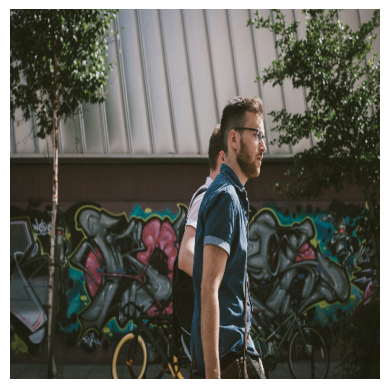

In [3]:
img = cv2.imread("0020.png")
img = cv2.resize(img,(512,512))
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.axis(False)
plt.show()

### Creating Gausian Noise in images 

In [4]:
sigma = 25
mean = 0
x,y,z = img_rgb.shape

gauss = np.random.normal(mean,sigma,(x,y,z)).astype(np.uint8)
noisy = cv2.add(img_rgb, gauss)

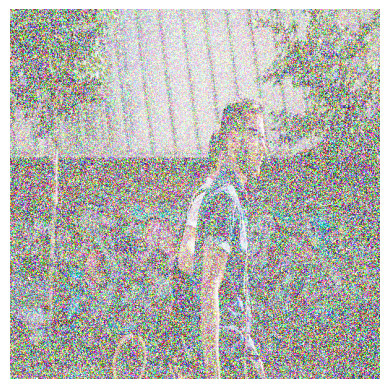

In [35]:
plt.imshow(noisy)
plt.axis(False)
plt.show()

In [6]:
def Gen_Gauss_Noise(image,noise_lvl = 25):
    x,y,z = image.shape
    mean = 0
    
    sigma = noise_lvl
    gauss = np.random.normal(mean,sigma,(x,y,z)).astype(np.uint8)
    noisy_img = cv2.add(image,gauss)
    
    return noisy_img

### Feature Collection

In [37]:
img = cv2.imread("0020.png")
img = cv2.resize(img,(512,512))

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
mean_blur = cv2.blur(gray,(3,3))
median_blur = cv2.medianBlur(gray,ksize=3)
laplacian = cv2.Laplacian(gray,cv2.CV_64F)
sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=3)
sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=3)

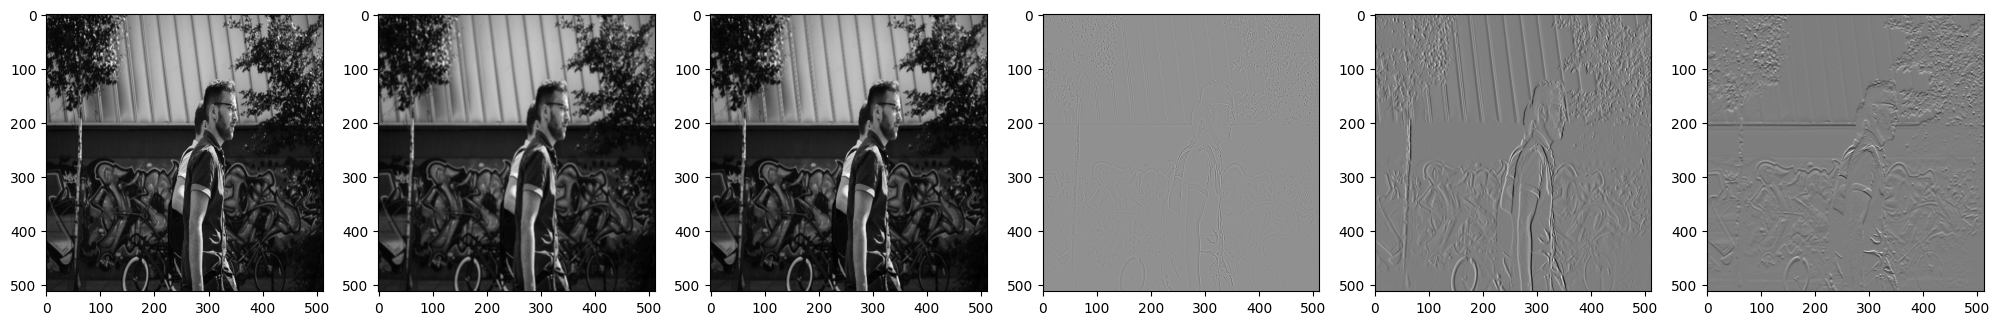

In [40]:
fig,ax = plt.subplots(ncols=6,figsize = (25,20))
ax[0].imshow(gray,cmap = "gray")
ax[1].imshow(mean_blur,cmap = "gray")
ax[2].imshow(median_blur,cmap = "gray")
ax[3].imshow(laplacian,cmap = "gray")
ax[4].imshow(sobelx,cmap = "gray")
ax[5].imshow(sobely,cmap = "gray")
plt.show()

In [41]:
def Feature_Collection(image):
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    mean_blur = cv2.blur(gray,(3,3))
    median_blur = cv2.medianBlur(gray,ksize=3)
    laplacian = cv2.Laplacian(gray,cv2.CV_64F)
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=3)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=3)
    
    feature_stack = np.stack([gray,mean_blur,median_blur,laplacian,sobelx,sobely])
    return feature_stack.reshape(-1, 6)

### Applying Preprocessing Functions to all images

In [ ]:
folder = "Data/DIV2K_train_HR"
X = []
y = []
for i in os.listdir(folder):
    img_path = os.path.join(folder,i)
    if img_path is None:
        continue
    
    img = cv2.imread(img_path)
    img = cv2.resize(img,(512,512))
    clean_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    noisy_img = Gen_Gauss_Noise(img)
    print(f"[{i}] - noisy image generated")
    
    feature_stack = Feature_Collection(noisy_img)
    print(f"[{i}] - feature stack created")
    
    X.append(feature_stack)
    y.append(clean_gray)
    print(f"[{i}] - Data appended!")

[0001.png] - noisy image generated
[0001.png] - feature stack created
[0001.png] - Data appended!
[0002.png] - noisy image generated
[0002.png] - feature stack created
[0002.png] - Data appended!
[0003.png] - noisy image generated
[0003.png] - feature stack created
[0003.png] - Data appended!
[0004.png] - noisy image generated
[0004.png] - feature stack created
[0004.png] - Data appended!
[0005.png] - noisy image generated
[0005.png] - feature stack created
[0005.png] - Data appended!
[0006.png] - noisy image generated
[0006.png] - feature stack created
[0006.png] - Data appended!
[0007.png] - noisy image generated
[0007.png] - feature stack created
[0007.png] - Data appended!
[0008.png] - noisy image generated
[0008.png] - feature stack created
[0008.png] - Data appended!
[0009.png] - noisy image generated
[0009.png] - feature stack created
[0009.png] - Data appended!
[0010.png] - noisy image generated
[0010.png] - feature stack created
[0010.png] - Data appended!
[0011.png] - noisy i

### Spliting the Data

In [ ]:
X = np.vstack(X)
y = np.hstack(y)
print(X.shape)
print(y.shape)


[[140.  97. 231. 232. 110. 230.]
 [255. 188. 160. 255. 157. 255.]
 [170. 102. 164. 170. 125. 247.]
 ...
 [  0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.]]
[[70 60 45 ...  1  1  1]
 [74 65 54 ...  1  1  1]
 [73 66 61 ...  1  1  1]
 ...
 [15 14 21 ... 46 40 47]
 [16 15 45 ... 32 35 28]
 [25 27 32 ... 34 24 30]]


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=5)
print(X_train.shape)

ValueError: Found input variables with inconsistent numbers of samples: [209715200, 512]